# Modelling direct and indirect pathways as two agents in a multi-armed bandit problem #




## Classic case ##

$q_{t+1} \leftarrow  q_t + \alpha (r_t - q_t)$


## New formulation ##

Neighbours update: index wise and relative to proximity in q

Two agents / two pathways, mediating direct and indirect pathways


### New update rule ###

$q^p(a_j)_{t+1} \leftarrow  q(a_j)_t + (-1)^p \alpha^p (r_t - q (a_j)_t)  \cdot g^p(a_j-a_k) \cdot f^p(r_t)$

$q_{t+1} = \sum_{j \in p} \beta_j q^j_{t+1}$

# Things to do here:

* Simplify the code - make an agent class and a data analysis class to organise the functions
* plotting: put the final plots into one matrix so that the simulation results are fully observable
* formalise the parameter space
    * what types of behaviours are we expecting given a set of parameters?
* formalise the bandit statistics a la Gershman // see paper

What we're after:
* a set of conditions that make the two pathways useful / write this down in the main manuscript?
* comparing with simple bandit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline

In [2]:
class world(object):
    def __init__(self):
        self.current_state = 0
        self.current_action = 0
        #return

    def get_outcome(self, current_state, current_action): #added current_state and current_action input arguments
        for k in range(current_state): #function to define outcomes given the state and action
            for i in range(current_action):
                outcome = current_state
        
        #return
    
    def get_all_outcomes(self):
        
        outcomes = {}
        for state in range(self.n_states):
            for action in range(1 if self.n_actions == 0 else self.n_actions):
                next_state, reward = self.get_outcome(state, action)
                outcomes[state, action] = [(1, next_state, reward)]
        return outcomes

In [3]:
class n_armed_bandit(world):
    
    def __init__(self, arm_number):
        self.name = "n_armed_bandit"
        self.n_states = 1
        self.n_actions = arm_number
        self.dim_x = 1
        self.dim_y = 1
        
        self.mu = [np.random.normal(0,1) for a in range(self.n_actions)]
        
    def get_outcome(self, state, action):
        
        self.rewards = [np.random.normal(self.mu[i],.1) for i in range(self.n_actions)]
        next_state = None
        
        reward = self.rewards[action]
        return int(next_state) if next_state is not None else None, reward

In [4]:
# auxiliary functions

# policy
def e_greedy_policy(q, epsilon):
    if np.random.uniform(0,1) > epsilon:
        return np.argmax(q)
    else:
        return np.random.choice(np.arange(len(q)))

# distance function
def gauss(arg, sigma): return np.exp(-np.power(arg,2)/sigma)

# softmax function
def soft_filter(x, amplitude, center, beta): return amplitude /(1 + np.exp(-beta*(x-center)))


#average reward with time
def compute_av_reward(cum_r):
    sum_r = np.zeros(len(cum_r))
    av_r = np.zeros(len(cum_r))
    sum_r[0] = cum_r[0]
    total_r=0
    n=1
    #len(cum_r)-1
    for k in range(0,len(cum_r)): 
        if cum_r[k] == 1:
            total_r =total_r+1
        sum_r[k] = (sum_r[k-1]+cum_r[k])
        av_r[k] = sum_r[k]/n
        n= n+1
    
    return av_r

# data managing functions

def invert_matrix(matrix):

    inverted_matrix = np.zeros([len(matrix[0]),len(matrix)])

    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
        
            inverted_matrix[j][i] = matrix[i][j]
            
    return inverted_matrix

def invert_tensor3(matrix):

    inverted_matrix = np.zeros([2,len(matrix[0][0]),len(matrix)])

    for i in range(len(matrix)):
        for j in range(len(matrix[0][0])):
            for k in range(2):
                inverted_matrix[k][j][i] = matrix[i][k][j]
            
    return inverted_matrix

In [5]:
#the transfer function only depends on r_threshold

def experiment_pathways_fr(n_pulls, k_arms, alpha_input, epsilon, sigma, r_threshold_input, weight):
    
    #initialization
    q = np.zeros(k_arms)
    r = 0
    a = randint(k_arms)
    s = 0
        
    n = np.zeros(k_arms)
    
    q_pathways_history = np.zeros([n_pulls, 2, k_arms])
    q_history = np.zeros([n_pulls, k_arms])
    q_pathways = np.zeros([2, k_arms])

    weight_history = np.zeros([n_pulls, 2])
    
    q_delta = np.zeros([2,k_arms])
    q_delta_history = []
    
    r_history = np.zeros(n_pulls)
    r_threshold_history = np.zeros(n_pulls)
    a_history = []
    greedy_bool = 0
    a_greedy_bool_list = []
    
    alpha = np.zeros(len(alpha_input))
    
    bandit = n_armed_bandit(k_arms)
    
    #actual value of the bandit, stationary
    bandit_mu = bandit.mu
    
    #determines wheter a pathway is activated (1) or not (0)
    update_factor = np.zeros(2)

    #matrix for action visitation per pathway
    p_visits = np.zeros([2,k_arms])
    
    delta_q = np.zeros([k_arms,2])
    
    r_threshold = 0
        
    for t in range(1,n_pulls):
                
        #r = compute_reward(a)
        s, r = bandit.get_outcome(s,a)
        
        r_history[t] = r
        
        #dynamic reward threshold
        if r_threshold_input == None:
            #r_threshold = np.mean(r_history)
            r_threshold = np.quantile(r_history, 0.75)
        else:
            r_theshold = r_threshold_input
            
        r_threshold_history[t] = r_threshold    
    
        if r >= r_threshold: #condition for direct pathway activation
            update_factor[0] = 1
            p_visits[0][a]+=1
    
        if r < r_threshold: #condition for indirect pathway activation
            update_factor[1] = 1 
            p_visits[1][a]+=1
                    
        for i in range(len(alpha_input)): #dynamic alpha

            if alpha_input[i] == None:
                alpha[i] = 1/p_visits[i].sum()
            
                if p_visits[i].sum() == 0:
                    alpha[i] = 0.1
            
            else:
                alpha[i] = alpha_input[i]
                  
        #action value update
        for action in range(k_arms):
            delta_q[action] = np.power(-1,[0,1]) * alpha * (r - q[a])* gauss(a-action, sigma) * update_factor

        q_pathways = np.outer(q, np.ones(2)) + delta_q

        q = (np.outer(np.ones(k_arms),weight) * q_pathways).sum(axis=1)

                
        #dynamic epsilon
        #during the first 10% of the pulls, the agent has a dynamic epsilon
        if t <= int(0.1*n_pulls):
            slope = (epsilon[1] - epsilon[0])/(0.1*n_pulls)
            eps = epsilon[0] + slope * t
        
        else:
            eps = epsilon[1]
        
        a = e_greedy_policy(q, eps)
        
        #saving variables        
        q_pathways_history[t] = np.transpose(q_pathways)

        q_history[t] = q

        weight_history[t] = weight
        
        a_greedy_bool_list.append(greedy_bool)
        a_history.append(a)
        
        q_delta_history.append(q_delta)

                
    return q, q_history, q_pathways_history, r_history, a_history, a_greedy_bool_list, bandit_mu, weight_history, q_delta_history, r_threshold_history

In [6]:
# the transfer function depends on r-q

def experiment_pathways_frq(n_pulls, k_arms, alpha_input, epsilon, sigma, r_threshold_input, weight):
    
    #initialization
    q = np.zeros(k_arms)
    r = 0
    a = randint(k_arms)
    s = 0
        
    n = np.zeros(k_arms)
    
    # simulation vectors
    q_pathways_history = np.zeros([n_pulls, 2, k_arms])
    q_history = np.zeros([n_pulls, k_arms])
    q_pathways = np.zeros([2, k_arms])
    weight_history = np.zeros([n_pulls, 2])
    q_delta = np.zeros([2,k_arms])
    q_delta_history = []
    r_history = np.zeros(n_pulls)
    a_history = []
    greedy_bool = 0
    a_greedy_bool_list = []
    alpha = np.zeros(len(alpha_input))
    
    # define the bandit
    bandit = n_armed_bandit(k_arms)
    
    #actual value of the bandit, stationary
    bandit_mu = bandit.mu
    
    #determines wheter a pathway is activated (1) or not (0)
    update_factor = np.zeros(2)

    #matrix for action visitation per pathway
    p_visits = np.zeros([2,k_arms])
    
    # reward prediction error
    delta_q = np.zeros([k_arms,2])
        
    for t in range(1,n_pulls):
                
        s, r = bandit.get_outcome(s,a)
        r_history[t] = r
        
        #dynamic reward threshold
        if r_threshold_input == None:
            #r_threshold = np.mean(r_history)
            r_threshold = np.quantile(r_history, 0.75)
        else:
            r_theshold = r_threshold_input
            
        r_threshold_history[t] = r_threshold  
        
        if r >= (r_threshold - q[a]): #condition for direct pathway activation
            update_factor[0] = 1
            p_visits[0][a]+=1
    
        if r < (r_threshold - q[a]): #condition for indirect pathway activation
            update_factor[1] = 1 
            p_visits[1][a]+=1
                    
        for i in range(len(alpha_input)): #dynamic alpha

            if alpha_input[i] == None:
                alpha[i] = 1/p_visits[i].sum()
            
                if p_visits[i].sum() == 0:
                    alpha[i] = 0.1
            
            else:
                alpha[i] = alpha_input[i]
                  
        #action value update
        for action in range(k_arms):
            delta_q[action] = np.power(-1,[0,1]) * alpha * np.abs(r - q[a])* gauss(a-action, sigma) * update_factor

        q_pathways = np.outer(q, np.ones(2)) + delta_q
        q = (np.outer(np.ones(k_arms),weight) * q_pathways).sum(axis=1)
                
        #dynamic epsilon
        #during the first 10% of the pulls, the agent has a dynamic epsilon
        if t <= int(0.1*n_pulls):
            slope = (epsilon[1] - epsilon[0])/(0.1*n_pulls)
            eps = epsilon[0] + slope * t
        
        else:
            eps = epsilon[1]
        
        a = e_greedy_policy(q, eps)
        
        #saving variables        
        q_pathways_history[t] = np.transpose(q_pathways)
        q_history[t] = q
        weight_history[t] = weight
        a_greedy_bool_list.append(greedy_bool)
        a_history.append(a)
        q_delta_history.append(q_delta)

                
    return q, q_history, q_pathways_history, r_history, a_history, a_greedy_bool_list, bandit_mu, weight_history, q_delta_history, r_threshold_history

Run code below to see an experiment using the transfer function as dependent of r only

In [7]:
n_pulls = 50000
k_arms  = 40
alpha = [None,None]
epsilon = [1,0.01]
sigma = [5,5]
r_threshold = None
weight = [0.5,0.5]

q, q_history, q_pathways_history, r_history, a_history, a_greedy_bool_list, bandit_mu, weight_history, q_delta_history,r_threshold_history = experiment_pathways_fr(n_pulls, k_arms, alpha, epsilon, sigma, r_threshold, weight)

/home/gongui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in double_scalars


Run code below to see an experiment using the transfer function as dependent of r-q

In [38]:
n_pulls = 50000
k_arms  = 40
alpha = [None,None]#[None,None]
epsilon = [1,0.01]
sigma = [5,5]
r_threshold = None
weight = [0.5,0.5]

q, q_history, q_pathways_history, r_history, a_history, a_greedy_bool_list, bandit_mu, weight_history, q_delta_history, r_threshold_history = experiment_pathways_frq(n_pulls, k_arms, alpha, epsilon, sigma, r_threshold, weight)

/Users/indp/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in double_scalars


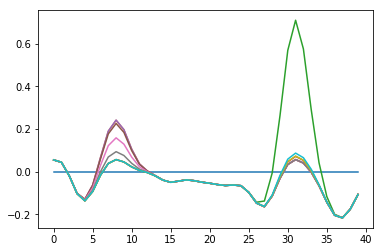

q max: 0.8077190827658851


In [8]:
for i in np.linspace(0,q_history.shape[0]-1,10).astype(int):
    plt.plot(q_history[i,:])

plt.show()

print('q max: ' + str(np.max(q_history)))

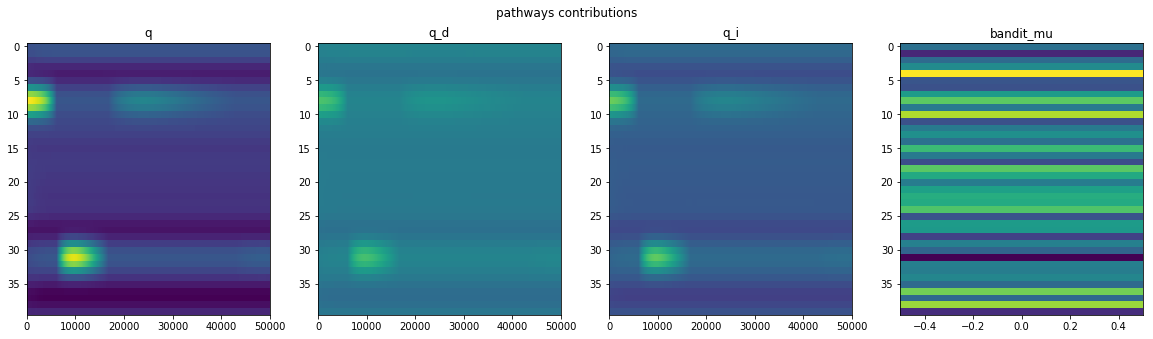

In [9]:
q_direct = invert_tensor3(q_pathways_history)[0]
q_indirect = invert_tensor3(q_pathways_history)[1]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.suptitle('pathways contributions')
fig.set_size_inches(20,5)

ax1.imshow(invert_matrix(q_history), aspect = 'auto')
ax1.title.set_text('q')

ax2.imshow(q_direct, aspect = 'auto')
ax2.title.set_text('q_d')

ax3.imshow(q_indirect, aspect = 'auto')
ax3.title.set_text('q_i')

ax4.imshow(np.expand_dims(bandit_mu,axis=1), aspect = 'auto')
ax4.title.set_text('bandit_mu')

plt.show()

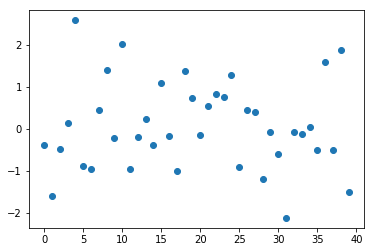

4


In [10]:
plt.plot(bandit_mu, 'o')
plt.show()

print(np.argmax(bandit_mu))

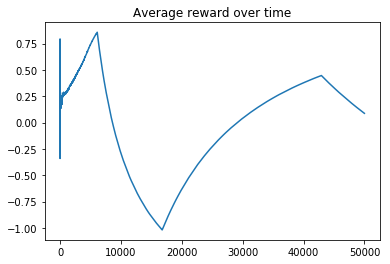

In [11]:
plt.plot(compute_av_reward(r_history))
plt.title('Average reward over time')
plt.show()

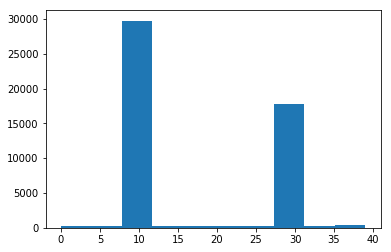

In [12]:
plt.hist(a_history)
plt.show()

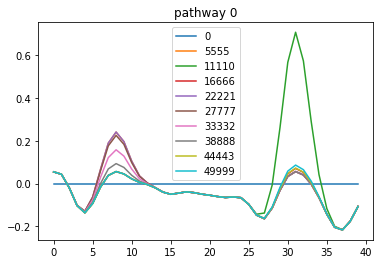

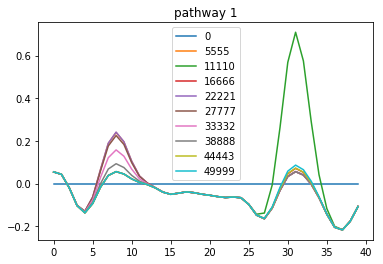

In [13]:
for p in range(2):

    for i in np.linspace(0,q_pathways_history.shape[0]-1,10).astype(int):
        plt.plot(q_pathways_history[i][p], label = i)
        plt.legend()
        plt.title('pathway ' + str(p))
        
    plt.show()

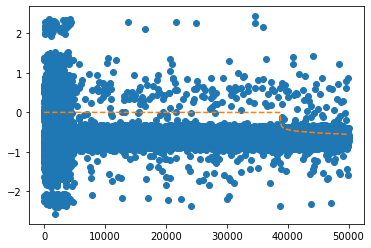

In [46]:
plt.plot(r_history,'o')
#plt.plot([0,200], [r_threshold, r_threshold], '--')
plt.plot(r_threshold_history, '--')
plt.show()

## Simulations##

* q dislaying actions distributed over rewards

* q after q_direct and q_indirect

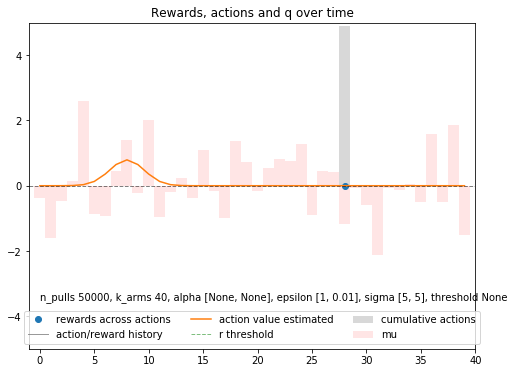

ValueError: Invalid file object: <_io.BufferedReader name=48>

In [14]:
from matplotlib.animation import FuncAnimation

xx = np.array(range(k_arms))

x = a_history
y = r_history
z = q_history

fig = plt.figure()
fig.set_size_inches(8,6)

parameters_to_print = 'n_pulls ' + str(n_pulls) + ', k_arms ' + str(k_arms) + ', alpha ' + str(alpha) + ', epsilon ' + str(epsilon) + ', sigma ' + str(sigma) + ', threshold ' + str(r_threshold)

plt.text(0,-3.5, parameters_to_print)

plt.xlim(-1, k_arms)
plt.ylim(-5, 5)

disp_history = 10

graph, = plt.plot([], [], 'o', label = 'rewards across actions')
ln, = plt.plot([], [], '-', color="grey", alpha = 0.8, linewidth = 1, animated=True, label = 'action/reward history')
acvalue, = plt.plot([],[],'-', label = 'action value estimated')
rects = plt.bar(xx, np.zeros(k_arms), 1, color='grey', alpha = 0.3, label = 'cumulative actions')
rects_mu = plt.bar(xx, bandit_mu, 1, color ='red', alpha = 0.1, label = 'mu')


def animate(i):
    if i > disp_history:
        ln.set_data([x[i-disp_history:i-1],x[i-disp_history+1:i]], [y[i-disp_history:i-1],y[i-disp_history+1:i]])
    
    graph.set_data(x[:i+1], y[:i+1])

    frequencies=np.bincount(x[:i+1])

    for rect, f in zip(rects, frequencies):
        rect.set_height(f/max(frequencies)*4.9)
    
    acvalue.set_data(xx,z[i+1])
    
    return graph, ln, rect, acvalue

ani = FuncAnimation(fig, animate, frames = 500)

plt.plot([-1,k_arms], [0,0],'--', color = 'black', alpha = 0.5, linewidth = 1)
plt.plot([-1, k_arms], [r_threshold,r_threshold], '--', color = 'green', alpha = 0.5, linewidth = 1, label = 'r threshold')

plt.title('Rewards, actions and q over time')
plt.legend(loc = 'lower center', ncol = 3)
plt.show()

ani.save('rewards_actions_time_q_' + parameters_to_print + '.mp4', fps = 25)

### Evolution of q as a function of the direct and indirect pathways ###

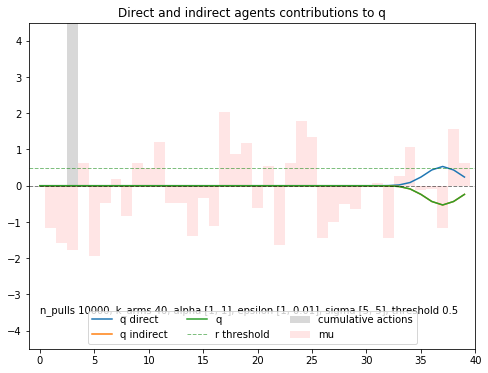

In [ ]:
x = a_history
z = q_history
xx = np.array(range(k_arms))
y = q_pathways_history


fig = plt.figure()
fig.set_size_inches(8,6)

plt.text(0,-3.5, parameters_to_print)

#plt.xlim(-1, 4)
#plt.ylim(-0.5, 1.5)
plt.xlim(-1, k_arms)
plt.ylim(-4.5, 4.5)

direct, = plt.plot([], [], '-', label = 'q direct')
indirect, = plt.plot([], [], '-', label = 'q indirect')

rects = plt.bar(xx, np.zeros(k_arms), 1, color='grey', alpha = 0.3, label = 'cumulative actions')
rects_mu = plt.bar(xx, bandit_mu, 1, color ='red', alpha = 0.1, label = 'mu')

acvalue, = plt.plot([],[],'-', label = 'q')


def animate(i):
    
    direct.set_data(xx, (y[i+1][0]-z[i+1]))#*10)
    
    indirect.set_data(xx, (y[i+1][1]-z[i+1]))#*10)

    frequencies=np.bincount(x[:i+1])

    for rect, f in zip(rects, frequencies):
        rect.set_height(f/max(frequencies)*4.9)
    
    acvalue.set_data(xx,z[i+1])#*4)
        
    return rect, direct, indirect, acvalue

ani = FuncAnimation(fig, animate, frames = 500)

plt.plot([-1,k_arms], [0,0],'--', color = 'black', alpha = 0.5, linewidth = 1)
plt.plot([-1, k_arms], [r_threshold,r_threshold], '--', color = 'green', alpha = 0.5, linewidth = 1, label = 'r threshold')

plt.title('Direct and indirect agents contributions to q')
plt.legend(loc = 'lower center', ncol = 3)
plt.show()

ani.save('q_evolution_' + parameters_to_print + '.mp4', fps = 25)

### Evolution of q as a function of the direct and indirect pathways, weighted over the transfer functions ###

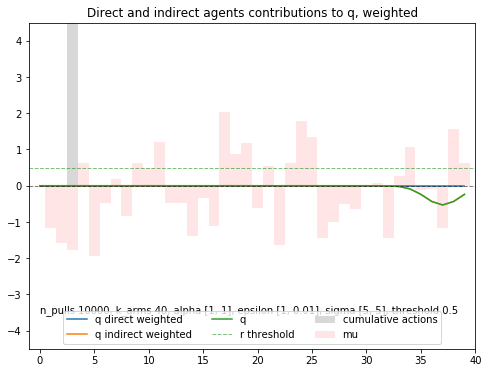

In [ ]:
x = a_history
z = q_history
xx = np.array(range(k_arms))
y = q_pathways_history


fig = plt.figure()
fig.set_size_inches(8,6)

plt.text(0,-3.5, parameters_to_print)

plt.xlim(-1, k_arms)
plt.ylim(-4.5, 4.5)

direct, = plt.plot([], [], '-', label = 'q direct weighted')
indirect, = plt.plot([], [], '-', label = 'q indirect weighted')
acvalue, = plt.plot([],[],'-', label = 'q')

rects = plt.bar(xx, np.zeros(k_arms), 1, color='grey', alpha = 0.3, label = 'cumulative actions')
rects_mu = plt.bar(xx, bandit_mu, 1, color ='red', alpha = 0.1, label = 'mu')


def animate(i):
    
    direct.set_data(xx, y[i+1][0] * weight_history[i+1][0])
    
    indirect.set_data(xx, y[i+1][1] * weight_history[i+1][1])

    frequencies=np.bincount(x[:i+1])

    for rect, f in zip(rects, frequencies):
        rect.set_height(f/max(frequencies)*4.9)
    
    acvalue.set_data(xx,z[i+1])
        
    return rect, direct, indirect, acvalue

ani = FuncAnimation(fig, animate, frames = 500)

plt.plot([-1,k_arms], [0,0],'--', color = 'black', alpha = 0.5, linewidth = 1)
plt.plot([-1, k_arms], [r_threshold,r_threshold], '--', color = 'green', alpha = 0.5, linewidth = 1, label = 'r threshold')

plt.title('Direct and indirect agents contributions to q, weighted')
plt.legend(loc = 'lower center', ncol = 3)
plt.show()

ani.save('q_evolution_weighted_' + parameters_to_print + '.mp4', fps = 25)